In [1]:
import scanpy as sc
import scvi
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
sc.set_figure_params(figsize=(4, 4))
import numpy as np
import torch
from functions import *
%matplotlib inline  

/local/data/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/local/data/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:84: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  dispatcher = jit(_target='npyufunc',
/local/data/anaconda3/envs/BT/lib/python3.11/site-pac

In [2]:
adata = scvi.data.heart_cell_atlas_subsampled()
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


In [3]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"]
)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [4]:
vaeSN = trainModelPostVis(adata,"sdnormal",200,log=False,logname="sd200epostvis",early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [02:34<00:00,  1.33it/s, v_num=1, train_loss_step=313, train_loss_epoch=304]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [02:34<00:00,  1.29it/s, v_num=1, train_loss_step=313, train_loss_epoch=304]


In [5]:
vaeMG = trainModelPostVis(adata, "mixofgaus", 400,prior_kwargs={"k":20},logname="mog200epostvis",log=False,early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [06:16<00:00,  1.05it/s, v_num=1, train_loss_step=385, train_loss_epoch=302]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:16<00:00,  1.06it/s, v_num=1, train_loss_step=385, train_loss_epoch=302]


In [6]:
vaeVP = trainModelPostVis(adata, "vamp", 400, prior_kwargs={"n_components":20}, logname="vamp200epostvis", log=False, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 317/400:  79%|███████▉  | 317/400 [05:35<01:27,  1.06s/it, v_num=1, train_loss_step=347, train_loss_epoch=303]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 330.098. Signaling Trainer to stop.


In [7]:
vaeNF = trainModelPostVis(adata,"normalflow",200,prior_kwargs={"num_layers":8},logname="flow200epostvis",log=False,early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200/200: 100%|██████████| 200/200 [06:16<00:00,  1.81s/it, v_num=1, train_loss_step=313, train_loss_epoch=304]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [06:16<00:00,  1.88s/it, v_num=1, train_loss_step=313, train_loss_epoch=304]


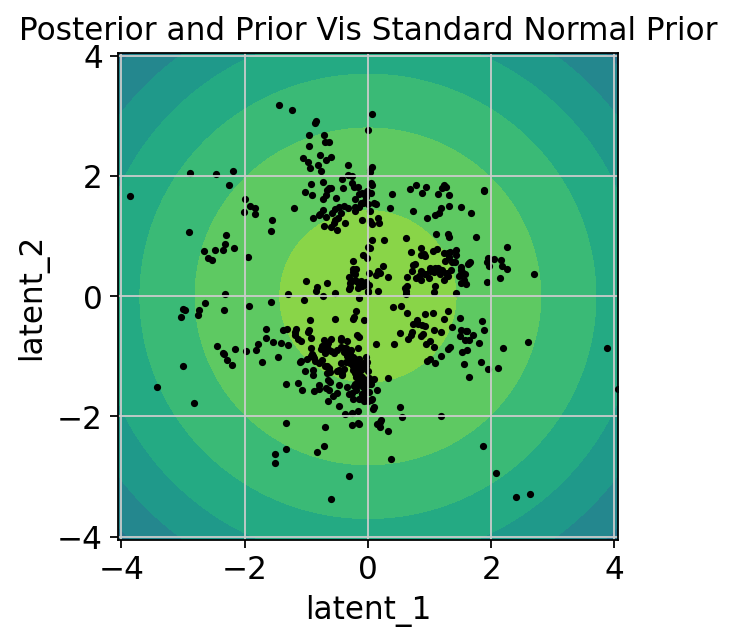

In [8]:
posteriorVisualization(adata, vaeSN, "Standard Normal")

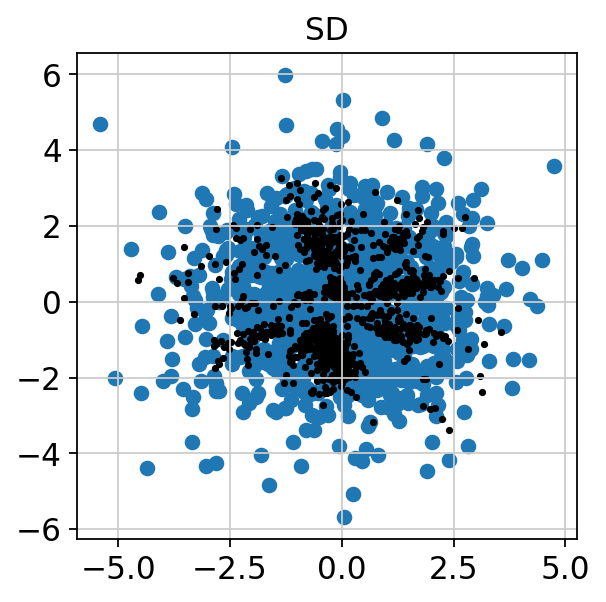

In [9]:
plotSamples(vaeSN.module.prior,num = 1000,title="SD")
plotPosterior(getPosteriorPoints(adata, vaeSN, num = 1000))

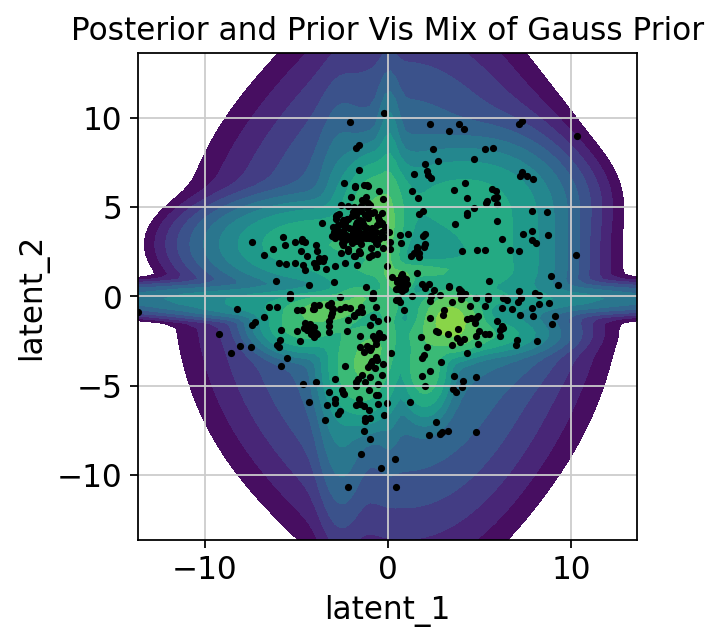

In [10]:
posteriorVisualization(adata, vaeMG,  "Mix of Gauss")

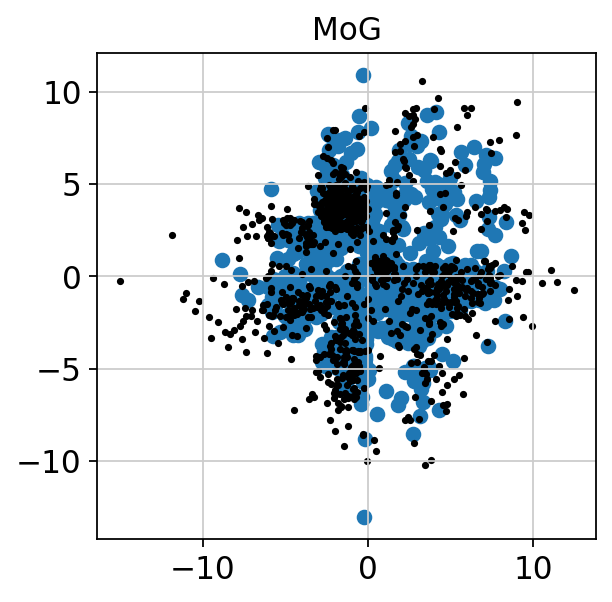

In [11]:
plotSamples(vaeMG.module.prior,num = 1000,title="MoG")
plotPosterior(getPosteriorPoints(adata, vaeMG, num = 1000))

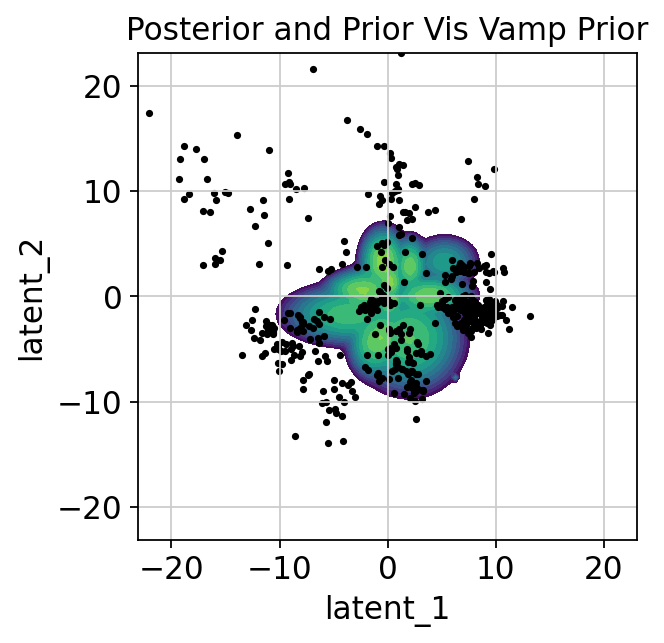

In [12]:
posteriorVisualization(adata, vaeVP,  "Vamp")

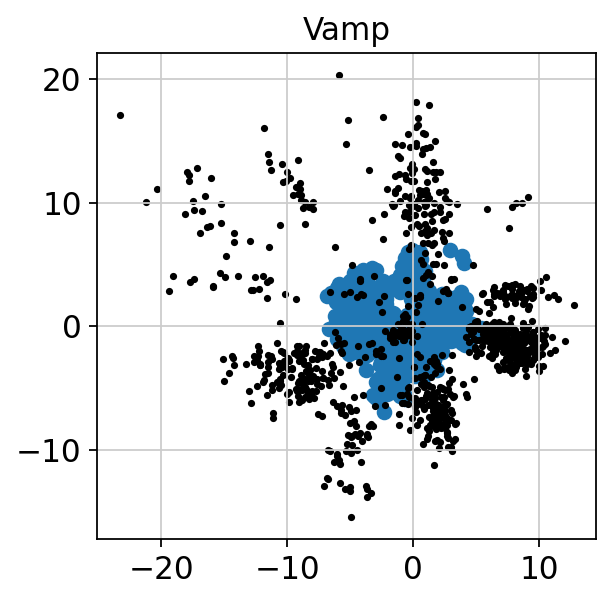

In [13]:
plotSamples(vaeVP.module.prior,num = 1000,title="Vamp")
plotPosterior(getPosteriorPoints(adata, vaeVP, num = 1000))

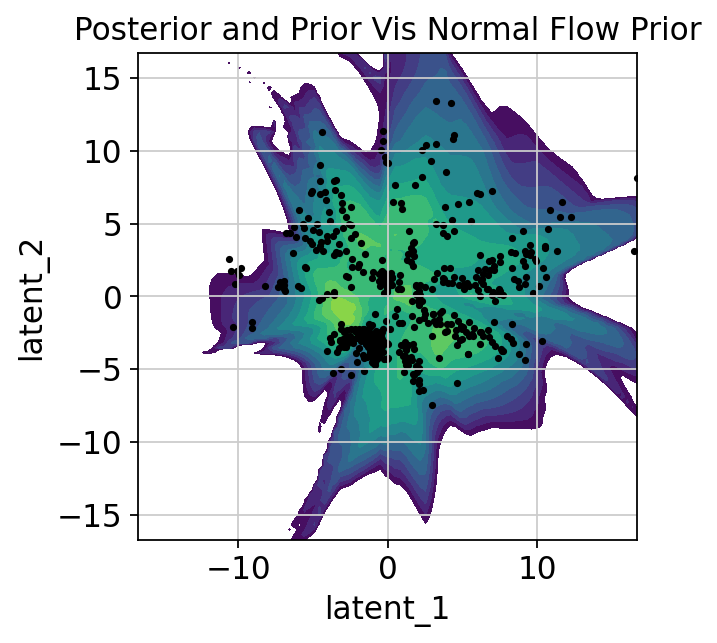

In [14]:
posteriorVisualization(adata, vaeNF,  "Normal Flow", flow=True)

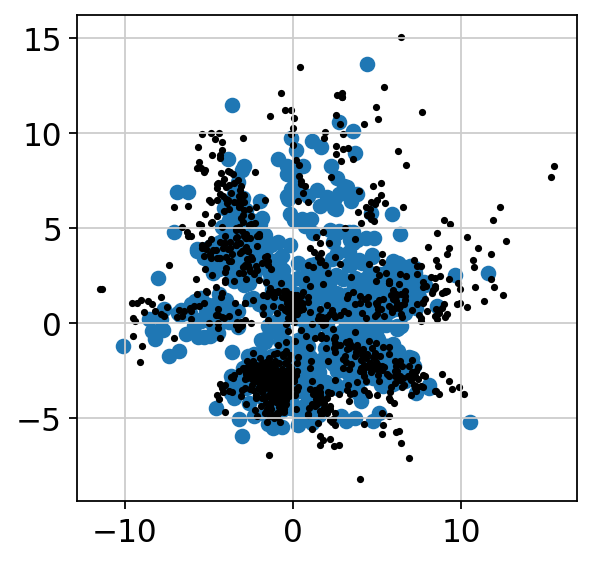

In [15]:
x = []; y = []
for i in range(1000):
    s1, _  = vaeNF.module.prior.sample(1)
    s = s1.cpu().detach()
    x.append(s[0,0].item())
    y.append(s[0,1].item())
plt.scatter(x,y)
plotPosterior(getPosteriorPoints(adata,vaeNF,1000))

In [64]:
def contourPlotDist(dist, xlim, ylim,flow=False):
    x = np.linspace(-xlim, xlim, 100)
    y = np.linspace(-ylim, ylim, 100)
    X, Y = np.meshgrid(x,y)
    Z = np.zeros_like(X)
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            if flow:
                Z[i][j] = dist.log_prob(torch.tensor([[float(x[i]),float(y[j])]]).to(torch.device('cuda:0'))).cpu().detach()
            else:
                Z[i][j] = dist.log_prob(torch.tensor([x[i],y[j]]).to(torch.device('cuda:0')))
    levels = np.linspace(-15.0, 0.0, 15)
    np.insert(levels, 0,-1000)
    plt.contourf(X,Y,Z,levels=levels)
    

In [24]:
def plotW(vae):
    plt.bar(np.linspace(1,20,20),torch.softmax(vae.module.prior.w,dim=0).detach().cpu())

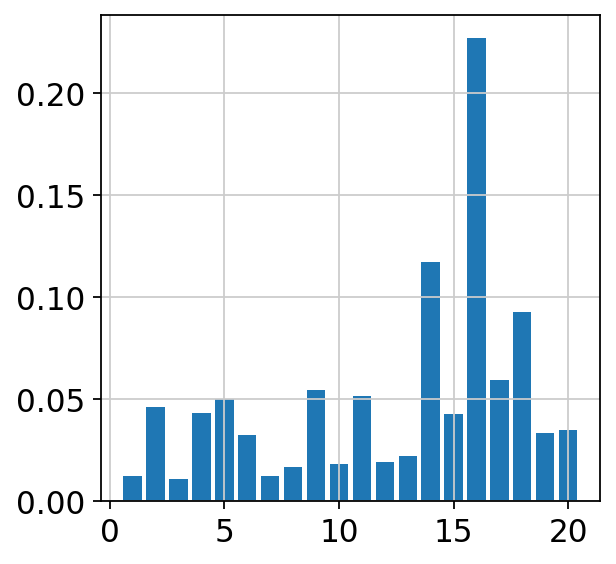

In [25]:
plotW(vaeMG)

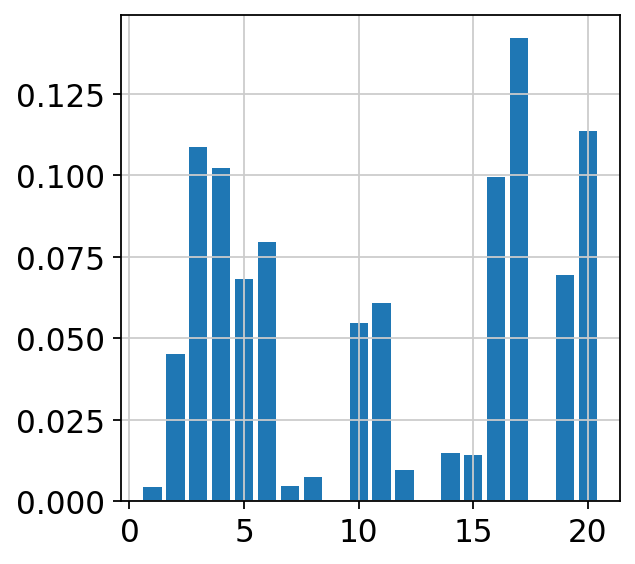

In [26]:
plotW(vaeVP)

In [33]:
def kl_term(vae, X):
    post, z = vae.module.z_encoder(X)
    log_q_zx = vae.module.prior.log_prob(z)
    log_p_z = post.log_prob(z)
    print(log_q_zx.sum(-1))
    print(log_p_z)
    kl_divergence_z = (log_q_zx.sum(-1) - log_p_z)
    return kl_divergence_z

In [34]:
kl_term(vaeMG,torch.tensor(adata.X[0].todense()))

tensor(-8.2352, grad_fn=<SumBackward1>)
tensor([[-0.8475, -0.0060]], grad_fn=<SubBackward0>)


tensor([[-7.3877, -8.2292]], grad_fn=<SubBackward0>)

In [39]:
vaeMG.module.loss(torch.tensor(adata.X.todense()),vaeMG.module.generative() )

type: sparse array length is ambiguous; use getnnz() or shape[0]

In [45]:
def covariance(adata, vae):
    dist, z = vae.module.z_encoder(torch.tensor(adata.X.todense()).to("cuda:0"))
    return torch.cov(z.T)


In [42]:
vaeTest = scvi.model.SCVI(adata, prior_distribution="sdnormal",n_latent=128)

In [50]:
vaeTest2 = scvi.model.SCVI(adata, prior_distribution="vamp",n_latent=128)

In [96]:
vaeTest3 = scvi.model.SCVI(adata, prior_distribution="normalflow",n_latent=128,prior_kwargs={"num_layers":8})